In [1]:
# Clear workspace
%reset

# standard packages
from math import e
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from scipy.stats import sem
pd.options.display.max_colwidth = 100

# SGL packages
from group_lasso import LogisticGroupLasso
LogisticGroupLasso.LOG_LOSSES = True

%reload_ext autoreload
%autoreload 2

working_dir = "~/Desktop/hif2gene"


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
seed = 360
np.random.seed(seed)

## Load in HIFs + Clusters 

In [3]:
# Load in HIF dataset with labels
# NAs removed, already converted to patient-level
df = pd.read_csv("{0}/data/genetic_data/TIGIT/datasets/lusc.TIGIT.joined.USE.csv".format(working_dir))
df = df.iloc[:,1:]
df

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._FFPE,AREA..MM2..OF..ESI_0080..IN..TISSUE._FFPE,AREA..MM2..OF..NECROSIS..IN..TISSUE._FFPE,AREA..MM2..OF..STROMA..IN..TISSUE._FFPE,AREA..MM2..OF..TUMOR..IN..TISSUE._FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_FFPE,...,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._FFPE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._FFPE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._FFPE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._FFPE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._FFPE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._FFPE,DENSITY..PLASMA.CELLS..IN..ESI_0080._FFPE,DENSITY..PLASMA.CELLS..IN..STROMA._FFPE,DENSITY..PLASMA.CELLS..IN..TUMOR._FFPE,joined.TIGIT_label
0,27.225548,20.799096,39.167736,85.021760,112.247308,5110.147301,5460.162356,4177.408629,4758.447487,4499.157584,...,886.586964,98.620604,447.423292,1028.560218,803.003668,17.153006,914.318584,1656.599440,1258.952241,1
1,26.648888,50.661880,21.445668,68.787860,95.436748,5902.693712,6204.851490,5660.053414,5775.615807,4904.934479,...,510.547572,134.939964,619.617748,1140.259342,859.543119,33.847566,562.138634,1058.835091,772.626913,0
2,52.244148,48.311188,6.086560,32.802492,85.046640,6767.115806,6598.832293,5307.369333,6009.020668,5909.048722,...,468.825106,188.499581,351.140196,1166.801595,565.830702,86.593431,288.483901,642.451189,300.987787,0
3,14.304372,13.492176,1.043028,17.688216,31.992588,6700.259693,6490.025315,4799.295929,6114.604178,6224.053279,...,367.928972,328.291239,515.632171,1341.288460,888.362017,61.869196,97.019191,183.285867,128.998629,0
4,108.472596,139.476556,40.770468,102.949824,211.422420,6523.976300,6178.594212,5890.749941,6504.132661,5345.874892,...,574.111298,600.824562,794.534961,880.788295,737.149825,72.267101,307.463858,546.839206,303.354772,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,68.523012,85.173192,111.656488,59.804684,128.327696,6257.862859,6306.755071,5587.013131,6284.619255,3767.663380,...,859.385802,34.309642,140.995068,310.092768,162.833127,17.760457,73.403378,167.913269,87.736322,0
296,63.597184,70.101124,15.685304,37.812436,101.409620,6795.170377,6840.896120,5641.014115,6738.660953,5923.293362,...,725.404552,13.758471,50.270235,167.167225,70.959737,8.113567,206.301970,707.359875,268.840372,1
297,77.987908,106.847656,57.923272,95.313388,173.301296,6331.815097,5924.450521,5927.116040,6345.516412,5205.901012,...,679.498669,25.324439,84.278873,148.866810,93.271086,56.188198,252.537126,635.230803,374.653863,0
298,39.603288,65.279932,70.423856,49.194160,88.797448,6153.814813,5975.715902,5641.371296,6316.010061,5052.757209,...,897.334347,91.760058,255.331148,498.778717,317.250108,56.030701,437.025578,953.629455,553.304190,0


In [4]:
# Normalize HIFs and define X, y
X = df.iloc[:,:607]
X_normalized = (X-X.mean())/X.std()
X_normalized

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._FFPE,AREA..MM2..OF..ESI_0080..IN..TISSUE._FFPE,AREA..MM2..OF..NECROSIS..IN..TISSUE._FFPE,AREA..MM2..OF..STROMA..IN..TISSUE._FFPE,AREA..MM2..OF..TUMOR..IN..TISSUE._FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_FFPE,...,DENSITY..LYMPHOCYTE.CELLS..IN..STROMA._FFPE,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._FFPE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._FFPE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._FFPE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._FFPE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._FFPE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._FFPE,DENSITY..PLASMA.CELLS..IN..ESI_0080._FFPE,DENSITY..PLASMA.CELLS..IN..STROMA._FFPE,DENSITY..PLASMA.CELLS..IN..TUMOR._FFPE
0,-0.552376,-0.939490,0.586970,0.591882,0.087607,-1.513417,-1.090308,-1.805467,-2.355995,-0.873144,...,-0.571889,-0.210598,-0.297703,0.113060,0.646913,0.857673,-0.568499,1.973863,1.432806,2.040576
1,-0.567770,-0.258066,-0.066179,0.235479,-0.147340,-0.466900,-0.066082,0.148843,-0.845422,-0.376359,...,-1.165326,-0.832195,-0.188211,0.651824,0.918822,1.021613,-0.379047,0.671252,0.389012,0.726561
2,0.115516,-0.311705,-0.632242,-0.554552,-0.292553,0.674525,0.475788,-0.316039,-0.498798,0.852959,...,-0.802562,-0.901163,-0.026745,-0.188191,0.983434,0.169974,0.219521,-0.340917,-0.338062,-0.547773
3,-0.897317,-1.106224,-0.818122,-0.886375,-1.034044,0.586245,0.326138,-0.985743,-0.341998,1.238613,...,-1.311080,-1.067945,0.394686,0.326473,1.408187,1.105176,-0.061053,-1.049089,-1.139839,-1.012474
4,1.616579,1.768554,0.646039,0.985479,1.473692,0.353472,-0.102196,0.452930,0.236481,0.163476,...,-0.912635,-0.727124,1.216292,1.199107,0.287192,0.666726,0.056943,-0.270715,-0.505016,-0.541377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.550093,0.529432,3.258556,0.038260,0.312349,0.002083,0.074073,0.052567,-0.089513,-1.768699,...,-0.636563,-0.255562,-0.491581,-0.845696,-1.102052,-0.998544,-0.561606,-1.136437,-1.166682,-1.123962
296,0.418594,0.185509,-0.278479,-0.444563,-0.063862,0.711570,0.808716,0.123747,0.584774,0.870399,...,0.320659,-0.477034,-0.553537,-1.129557,-1.449975,-1.264938,-0.671080,-0.644884,-0.224721,-0.634632
297,0.802766,1.024011,1.278209,0.817827,0.940906,0.099733,-0.451738,0.500865,0.000924,-0.007891,...,-0.678109,-0.552917,-0.518669,-1.023150,-1.494524,-1.200244,-0.125522,-0.473873,-0.350670,-0.348732
298,-0.221942,0.075497,1.738920,-0.194686,-0.240132,-0.135307,-0.381229,0.124218,-0.042895,-0.195382,...,-0.101834,-0.192833,-0.318385,-0.487960,-0.642734,-0.550802,-0.127310,0.208495,0.205306,0.133968


In [5]:
y = df.iloc[:,607]
print(np.sum(y))

99


In [6]:
# Load in clusters
clusters = pd.read_csv("{0}/data/hif_clusters/LUSC.hif.clusters.csv".format(working_dir))
print("Number of Clusters: {0}".format(len(set(clusters['x']))))
clusters


Number of Clusters: 25


,Unnamed: 0,x
0,AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE,1
1,AREA (MM2) OF [ESI_0080] IN [TISSUE]_HE,1
2,AREA (MM2) OF [NECROSIS] IN [TISSUE]_HE,2
3,AREA (MM2) OF [STROMA] IN [TISSUE]_HE,3
4,AREA (MM2) OF [TUMOR] IN [TISSUE]_HE,1
...,...,...
602,TOTAL [MACROPHAGE CELLS] IN [TUMOR]_HE,1
603,TOTAL [PLASMA CELLS] IN [EPITHELIAL]_HE,1
604,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,3
605,TOTAL [PLASMA CELLS] IN [STROMA]_HE,3


## Define Nested CV Parameters

In [7]:
num_outer_loops = 3 # for estimating generalization error
num_inner_loops = 5 # for hyper-parameter tuning
training_aurocs = [0.0, 0.0, 0.0]
generalization_aurocs = [0.0, 0.0, 0.0]
training_auprcs = [0.0, 0.0, 0.0]
generalization_auprcs = [0.0, 0.0, 0.0]

# Define outer loops (A, B, and C)
X_train_AB, X_train_C, y_train_AB, y_train_C = train_test_split(X_normalized, y, test_size=1/3, random_state=seed, stratify=y)
X_train_A, X_train_B, y_train_A, y_train_B = train_test_split(X_train_AB, y_train_AB, test_size=1/2, random_state=seed, stratify=y_train_AB)

# Verify correctness
print(len(X_train_A), len(y_train_A))
print(len(X_train_B), len(y_train_B))
print(len(X_train_C), len(y_train_C))

print(np.sum(y_train_A)/len(y_train_A))
print(np.sum(y_train_B)/len(y_train_B))
print(np.sum(y_train_C)/len(y_train_C))

100 100
100 100
100 100
0.33
0.33
0.33


### Outer Loop 1

In [8]:
# Define outer loop train and test
X_train_1 = np.array(X_train_A.append(X_train_B))
y_train_1 = np.array(y_train_A.append(y_train_B))
print(X_train_1.shape, y_train_1.shape)

X_test_1 = np.array(X_train_C)
y_test_1 = np.array(y_train_C)
print(X_test_1.shape, y_test_1.shape)

(200, 607) (200,)
(100, 607) (100,)


In [9]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_1, y_train_1)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-7, -2, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_1, y_train_1):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_1[train_index], X_train_1[test_index]
        y_train, y_test = y_train_1[train_index], y_train_1[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.6002442002442003, 0.6013838013838014, 0.6071021571021571, 0.6082417582417583, 0.6093610093610093, 0.6116402116402117, 0.6195156695156696, 0.6217948717948717, 0.6335775335775334, 0.6380341880341881, 0.6560643060643061, 0.6463369963369964, 0.6621082621082621, 0.6847985347985348, 0.6763329263329265, 0.6731583231583231, 0.7032153032153031, 0.7077533577533579, 0.7095848595848595, 0.7159951159951159, 0.7486365486365487, 0.7577330077330078, 0.7594831094831094, 0.76003256003256, 0.756043956043956, 0.7537851037851038, 0.764041514041514, 0.5, 0.5, 0.5]


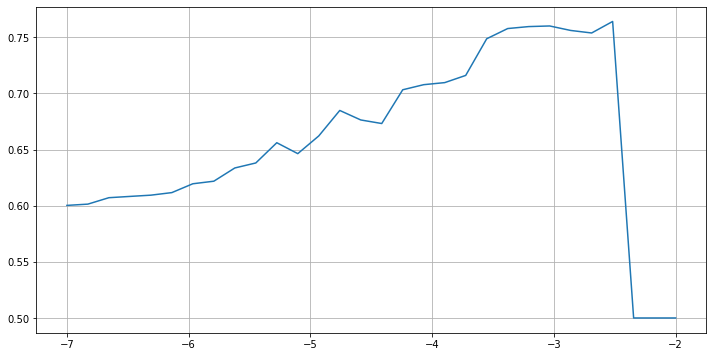

0.08068187071542855 -2.5172413793103443


In [12]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.6
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_1, y_train_1)

# Store optimal model
optimal_sgl_1 = optimal_sgl

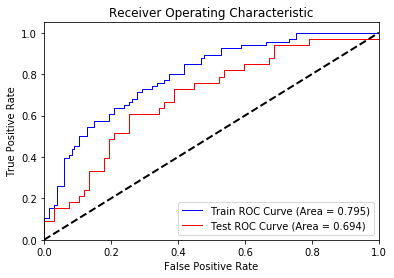

In [10]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_1)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_1)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_1, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[0] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_1, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[0] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

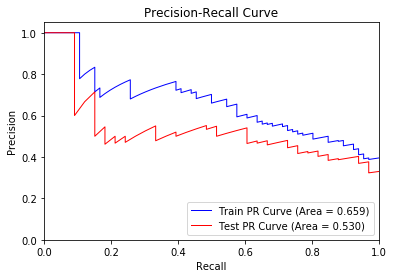

In [11]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_1, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[0] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_1, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[0] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [12]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_1 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_1[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_1, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 21


,HIF,Beta,Cluster
508,REGION PROPERTIES: PERIMETER^2 / AREA OF LARGEST REGION OF EPITHELIAL_HE,0.235103,18
155,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF FIBROBLAST IN TUMOR_HE,0.107539,8
95,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF FIBROBLAST IN TUMOR_HE,0.096600,8
154,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF FIBROBLAST IN STROMA_HE,0.077487,8
55,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF FIBROBLAST IN TUMOR_HE,0.065500,8
114,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF FIBROBLAST IN STROMA_HE,0.059555,8
174,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF FIBROBLAST IN STROMA_HE,0.055962,8
94,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF FIBROBLAST IN STROMA_HE,0.054354,8
175,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF FIBROBLAST IN TUMOR_HE,0.051769,8
115,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF FIBROBLAST IN TUMOR_HE,0.044701,8


### Outer Loop 2

In [13]:
# Define outer loop train and test
X_train_2 = np.array(X_train_A.append(X_train_C))
y_train_2 = np.array(y_train_A.append(y_train_C))
print(X_train_2.shape, y_train_2.shape)

X_test_2 = np.array(X_train_B)
y_test_2 = np.array(y_train_B)
print(X_test_2.shape, y_test_2.shape)

(200, 607) (200,)
(100, 607) (100,)


In [26]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_2, y_train_2)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_2, y_train_2):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_2[train_index], X_train_2[test_index]
        y_train, y_test = y_train_2[train_index], y_train_2[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.6654606498622672, 0.6606367998578242, 0.6655867717188473, 0.675450282870768, 0.6482932969994964, 0.6552173513817718, 0.6609059565771156, 0.6704189745564408, 0.674192796421907, 0.6497370930955836, 0.6418709161458487, 0.6467266076241818, 0.6566097272000236, 0.6524746008708273, 0.6514022985101151, 0.6294057936672492, 0.6542973253161932, 0.7000427712449275, 0.6969045348182814, 0.7008240869642488, 0.6817453570688071, 0.6938215692663132, 0.6759051272177956, 0.6682973845561447, 0.6541494327774651, 0.6750949616421315, 0.6786153549954088, 0.6879549776369183, 0.6213567726074465, 0.6824247504517047]


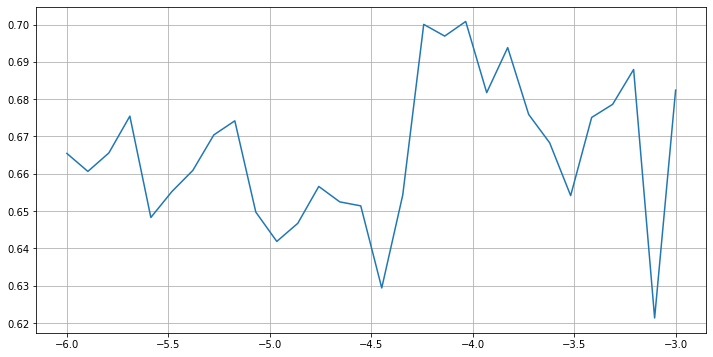

0.01769483024496462 -4.0344827586206895


In [33]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.6
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_2, y_train_2)

# Store optimal model
optimal_sgl_2 = optimal_sgl

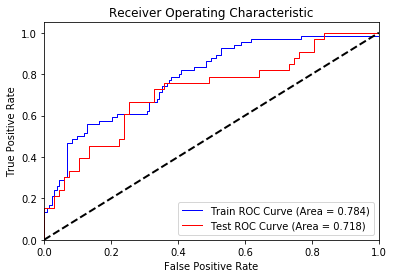

In [15]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_2)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_2)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_2, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[1] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[1] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

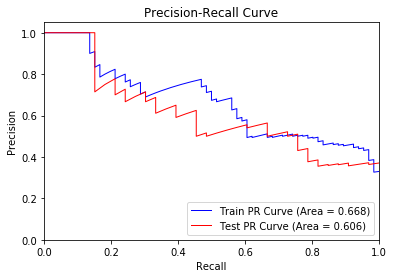

In [16]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_2, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[1] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_2, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[1] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [17]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_2 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_2[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_2, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 59


,HIF,Beta,Cluster
475,REGION PROPERTIES: LACUNARITY OF LARGEST REGION OF NECROSIS_HE,0.910896,21
423,REGION PROPERTIES: AVERAGE ECCENTRICITY OF SIGNIFICANT REGIONS OF NECROSIS_HE,0.235397,20
528,REGION PROPERTIES: STANDARD DEVIATION OF ECCENTRICITIES OF SIGNIFICANT REGIONS OF NECROSIS_HE,0.121433,20
94,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF FIBROBLAST IN STROMA_HE,0.062865,8
211,COUNT PROP [FIBROBLAST CELLS] IN [[TUMOR] OVER [STROMA]]_HE,0.061168,16
155,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF FIBROBLAST IN TUMOR_HE,0.051066,8
348,DENSITY RATIO [FIBROBLAST CELLS] IN [[ESI_0080] OVER [STROMA]]_HE,0.026772,4
476,REGION PROPERTIES: LACUNARITY OF LARGEST REGION OF STROMA_HE,0.026437,24
382,DENSITY RATIO [PLASMA CELLS] IN [[EPITHELIAL] OVER [TUMOR]]_HE,0.023992,11
254,COUNT PROP [[CANCER CELLS] OVER [[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]]] IN [STROMA]_HE,0.022618,17


### Outer Loop 3

In [18]:
# Define outer loop train and test
X_train_3 = np.array(X_train_B.append(X_train_C))
y_train_3 = np.array(y_train_B.append(y_train_C))
print(X_train_3.shape, y_train_3.shape)

X_test_3 = np.array(X_train_A)
y_test_3 = np.array(y_train_A)
print(X_test_3.shape, y_test_3.shape)

(200, 607) (200,)
(100, 607) (100,)


In [33]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_3, y_train_3)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_3, y_train_3):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_3[train_index], X_train_3[test_index]
        y_train, y_test = y_train_3[train_index], y_train_3[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.6601139601139601, 0.6634717134717134, 0.6650997150997151, 0.6701465201465202, 0.6723646723646723, 0.6757427757427757, 0.6898656898656899, 0.6806878306878307, 0.6954415954415956, 0.6888074888074888, 0.704985754985755, 0.697883597883598, 0.6989214489214489, 0.7023606023606024, 0.7176027676027676, 0.7076312576312578, 0.7105413105413106, 0.7072853072853074, 0.7032153032153033, 0.6974765974765976, 0.6907203907203907, 0.683943833943834, 0.6828042328042329, 0.7039479039479039, 0.7274318274318274, 0.7241554741554741, 0.7270858770858771, 0.7277370777370777, 0.7249694749694751, 0.7137973137973138]


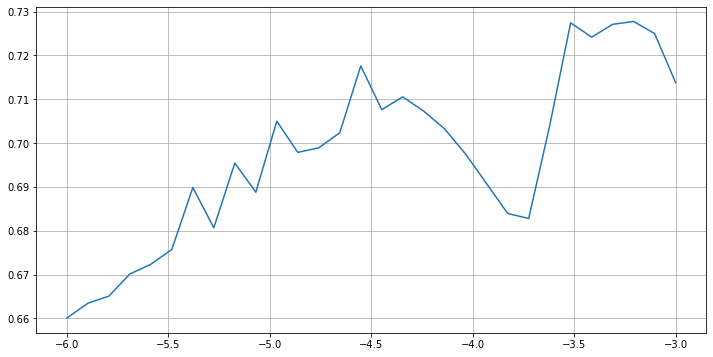

0.04048205248027766 -3.206896551724138


In [35]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.7
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_3, y_train_3)

# Store optimal model
optimal_sgl_3 = optimal_sgl

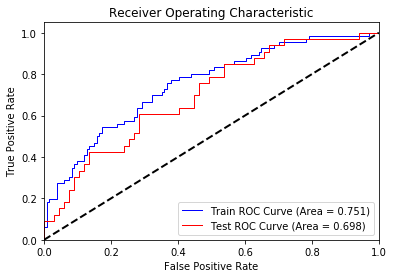

In [20]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_3)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_3)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_3, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[2] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_3, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[2] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

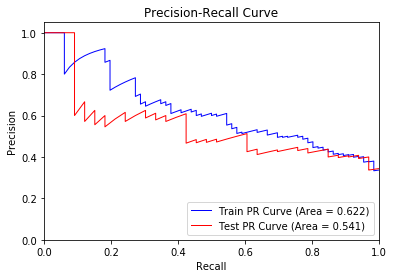

In [21]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_3, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[2] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_3, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[2] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [22]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_3 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_3[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_3, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 148


,HIF,Beta,Cluster
475,REGION PROPERTIES: LACUNARITY OF LARGEST REGION OF NECROSIS_HE,0.508814,21
23,CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF MACROPHAGE IN TUMOR_HE,0.119695,9
353,DENSITY RATIO [FIBROBLAST CELLS] IN [[TUMOR] OVER [EPITHELIAL]]_HE,0.059863,16
164,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF PLASMA IN EPITHELIAL_HE,0.044172,11
155,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF FIBROBLAST IN TUMOR_HE,0.035111,8
...,...,...,...
196,COUNT PROP [CANCER CELLS] IN [[STROMA] OVER [TUMOR]]_HE,-0.046009,7
307,COUNT PROP [[[CANCER CELLS] SELECTED BY [MACROPHAGE_RADIUS_80]] OVER [[CANCER CELLS] SELECTED BY...,-0.048610,13
504,REGION PROPERTIES: PERIMETER (MM) OF LARGEST REGION OF STROMA_HE,-0.053564,3
83,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT STANDARD DEVIATION OF MACROPHAGE IN TUMOR_HE,-0.214938,9


## Compute Ensemble Model

In [23]:
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta_1": betas_1, 
    "Beta_2": betas_2,
    "Beta_3": betas_3,
    "Cluster": clusters['x']
    }
)
betas_df['Beta'] = (betas_df['Beta_1'] + betas_df['Beta_2'] + betas_df['Beta_3'])/3.0
betas_df.sort_values(by="Beta", ascending=False)

,HIF,Beta_1,Beta_2,Beta_3,Cluster,Beta
475,REGION PROPERTIES: LACUNARITY OF LARGEST REGION OF NECROSIS_HE,0.000000,0.910896,0.508814,21,0.473237
423,REGION PROPERTIES: AVERAGE ECCENTRICITY OF SIGNIFICANT REGIONS OF NECROSIS_HE,0.000000,0.235397,0.000000,20,0.078466
508,REGION PROPERTIES: PERIMETER^2 / AREA OF LARGEST REGION OF EPITHELIAL_HE,0.235103,0.000000,0.000000,18,0.078368
155,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF FIBROBLAST IN TUMOR_HE,0.107539,0.051066,0.035111,8,0.064572
23,CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF MACROPHAGE IN TUMOR_HE,0.017334,0.008307,0.119695,9,0.048445
...,...,...,...,...,...,...
526,REGION PROPERTIES: STANDARD DEVIATION OF ECCENTRICITIES OF SIGNIFICANT REGIONS OF EPITHELIAL_HE,-0.065193,0.000000,0.000000,18,-0.021731
540,REGION PROPERTIES: STANDARD DEVIATION OF SOLIDITIES OF SIGNIFICANT REGIONS OF TUMOR_HE,-0.004630,-0.091827,0.000000,24,-0.032152
83,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT STANDARD DEVIATION OF MACROPHAGE IN TUMOR_HE,-0.004959,-0.033635,-0.214938,9,-0.084511
533,REGION PROPERTIES: STANDARD DEVIATION OF EXTENTS OF SIGNIFICANT REGIONS OF NECROSIS_HE,0.000000,-0.265864,0.000000,21,-0.088621


## Compute Final Train / Test Metrics

In [24]:
print(training_aurocs)
print(np.mean(training_aurocs), np.std(training_aurocs))

[0.7947761194029851, 0.7836951605608322, 0.7512437810945274]
0.7765716870194482 0.01847203338602443


In [25]:
print(generalization_aurocs)
print(np.mean(generalization_aurocs), np.std(generalization_aurocs))

[0.6942559927634555, 0.7182270465852555, 0.6978742650384442]
0.7034524347957184 0.010551140182073036


In [26]:
print(training_auprcs)
print(np.mean(training_auprcs), np.std(training_auprcs))

[0.659446446609484, 0.6675242143966306, 0.6220573735816011]
0.6496760115292385 0.019805798051206733


In [27]:
print(generalization_auprcs)
print(np.mean(generalization_auprcs), np.std(generalization_auprcs))

[0.5300191883898463, 0.6062481650846794, 0.5405907371941214]
0.5589526968895491 0.033720274760424


## Evaluate Hold-Out Set

In [28]:
holdout_df = pd.read_csv("{0}/data/genetic_data/TIGIT/datasets/lusc.tigit.joined.HOLDOUT.csv".format(working_dir))
holdout_df = holdout_df.iloc[:,1:]
holdout_df

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._FFPE,AREA..MM2..OF..ESI_0080..IN..TISSUE._FFPE,AREA..MM2..OF..NECROSIS..IN..TISSUE._FFPE,AREA..MM2..OF..STROMA..IN..TISSUE._FFPE,AREA..MM2..OF..TUMOR..IN..TISSUE._FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_FFPE,...,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._FFPE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._FFPE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._FFPE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._FFPE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._FFPE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._FFPE,DENSITY..PLASMA.CELLS..IN..ESI_0080._FFPE,DENSITY..PLASMA.CELLS..IN..STROMA._FFPE,DENSITY..PLASMA.CELLS..IN..TUMOR._FFPE,joined.TIGIT_label
0,44.614060,48.970184,52.671736,56.416952,101.031012,6681.995336,6068.722504,5635.209993,6415.732053,5631.244557,...,1802.080335,27.771514,117.214181,279.543638,168.364145,7.957133,290.830028,871.971956,490.433571,0
1,141.079780,133.991280,23.540920,102.211936,243.291716,6653.555564,6227.367567,5832.030841,6734.980601,6289.383036,...,848.536906,77.821216,213.051178,485.980424,249.297432,77.764510,468.970817,1453.978917,655.940953,0
2,155.368068,141.359540,39.170800,138.627560,293.995628,6641.103506,6431.448008,5484.909379,6555.388437,5134.730476,...,1450.477352,15.312027,126.118124,531.019950,258.483436,20.506144,516.533939,1832.940001,875.121857,0
3,106.002212,166.184464,44.307036,147.375092,253.377304,5903.440095,6007.808063,5381.069213,6023.511051,5435.350900,...,1001.391979,401.925575,373.530705,433.960713,420.558583,57.253522,300.334934,993.037548,601.545591,0
4,49.889124,31.114740,10.044648,44.979312,94.868436,6298.614026,5621.425514,5179.342346,6219.452140,3581.078568,...,912.516361,77.070906,325.794141,726.978661,385.207152,28.302762,202.347826,959.974666,470.029884,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,42.810968,71.876072,71.635612,89.004812,131.815780,5849.430848,5578.271804,4812.196856,5798.166444,3834.319094,...,936.640515,153.722289,459.735752,908.984561,663.691403,44.661452,400.147075,1116.310430,768.261584,0
94,47.872360,35.150752,10.031736,22.948752,70.821112,6923.732594,5998.358443,5186.177105,7016.332174,5264.516818,...,295.801625,127.798170,309.609308,481.159063,242.300629,18.841770,110.381707,250.122534,93.785593,0
95,20.681632,48.952788,4.349976,58.916880,79.598512,6355.898094,6468.830562,6701.191267,6498.534393,5199.748239,...,2456.804720,510.114482,853.822667,1636.780495,1344.045225,185.962114,1067.763495,1332.894749,1034.893718,1
96,107.337592,179.691200,79.234320,183.314796,290.652388,6385.322963,6357.834926,5874.068158,6455.274255,5648.279228,...,1707.974957,201.541693,410.454157,869.411545,622.767978,67.730232,444.390154,1118.382174,730.377622,0


In [29]:
# Normalize HIFs and define X, y
X_holdout = holdout_df.iloc[:,:607]
X_normalized_holdout = (X_holdout-X_holdout.mean())/X_holdout.std()
X_normalized_holdout

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._FFPE,AREA..MM2..OF..ESI_0080..IN..TISSUE._FFPE,AREA..MM2..OF..NECROSIS..IN..TISSUE._FFPE,AREA..MM2..OF..STROMA..IN..TISSUE._FFPE,AREA..MM2..OF..TUMOR..IN..TISSUE._FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_FFPE,...,DENSITY..LYMPHOCYTE.CELLS..IN..STROMA._FFPE,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._FFPE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._FFPE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._FFPE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._FFPE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._FFPE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._FFPE,DENSITY..PLASMA.CELLS..IN..ESI_0080._FFPE,DENSITY..PLASMA.CELLS..IN..STROMA._FFPE,DENSITY..PLASMA.CELLS..IN..TUMOR._FFPE
0,0.073592,-0.042802,1.845840,0.246177,0.194079,0.431513,-0.264523,0.245828,-0.087000,0.550957,...,2.070163,1.557713,-0.507775,-1.015373,-1.224906,-0.945588,-0.894761,-0.365753,-0.013349,0.066159
1,2.971639,2.046526,0.312700,1.294388,2.284979,0.390823,0.026964,0.533234,0.492852,1.374601,...,0.269106,-0.067530,-0.341187,-0.675170,-0.718101,-0.694503,0.337440,0.333475,1.089577,0.576855
2,3.400891,2.227595,1.135293,2.127913,3.030209,0.373008,0.401932,0.026352,0.166658,-0.070417,...,1.829047,0.958432,-0.549245,-0.983766,-0.607529,-0.666005,-0.673252,0.520167,1.807723,1.253168
3,1.917830,2.837649,1.405610,2.328137,2.433214,-0.682386,-0.376444,-0.125280,-0.799392,0.305801,...,-0.017562,0.193000,0.737574,-0.105499,-0.845810,-0.163188,-0.024608,-0.328445,0.216075,0.409011
4,0.232067,-0.481586,-0.397602,-0.015622,0.103504,-0.117001,-1.086365,-0.419851,-0.443503,-2.014773,...,0.197442,0.041518,-0.343685,-0.274955,-0.126447,-0.272861,-0.535631,-0.713059,0.153420,0.003201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,0.019423,0.520093,2.843900,0.992087,0.646543,-0.759658,-1.165654,-0.955973,-1.208685,-1.697849,...,-0.259883,0.082636,-0.088555,0.200512,0.320379,0.591098,-0.246877,0.063332,0.449682,0.923436
94,0.171479,-0.382404,-0.398282,-0.519884,-0.249936,0.777372,-0.393806,-0.409870,1.003871,0.092007,...,-1.063212,-1.009626,-0.174842,-0.332408,-0.729938,-0.716210,-0.702631,-1.074039,-1.191778,-1.157754
95,-0.645392,-0.043229,-0.697310,0.303398,-0.120929,-0.035043,0.470617,1.802421,0.063394,0.010951,...,1.960462,2.673642,1.097674,1.599443,2.107127,2.701805,2.247283,2.683821,0.860118,1.746167
96,1.957948,3.169566,3.243816,3.150768,2.981071,0.007056,0.266679,0.594619,-0.015179,0.572276,...,1.307297,1.397318,0.070609,0.025572,0.223227,0.464139,0.160321,0.236992,0.453608,0.806540


In [30]:
y_holdout = holdout_df.iloc[:,607]
print(np.sum(y_holdout))

30


In [31]:
X_normalized_holdout = np.array(X_normalized_holdout)
y_pred_probs_1 = optimal_sgl_1.predict_proba(X_normalized_holdout)[1] # predicted probability y = 1
y_pred_probs_2 = optimal_sgl_2.predict_proba(X_normalized_holdout)[1]
y_pred_probs_3 = optimal_sgl_3.predict_proba(X_normalized_holdout)[1] 

In [32]:
# Ensemble (average) predictions
y_pred_probs_ensemble = np.mean(np.array([list(y_pred_probs_1), list(y_pred_probs_2), list(y_pred_probs_3)]), axis=0)
# y_pred_probs_ensemble

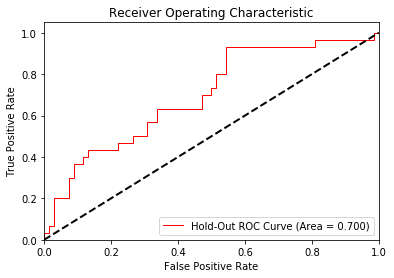

In [33]:
# Hold Out ROC
fpr, tpr, thresholds = roc_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Hold-Out ROC Curve (Area = %0.3f)' % roc_auc)

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Original ROC area: 0.700


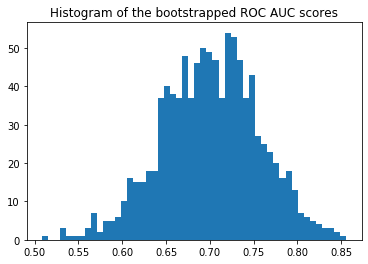

Confidence interval for the score: [0.587 - 0.807]


In [34]:
# Generate ROC 95% CI

print("Original ROC area: {:0.3f}".format(roc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_holdout[indices], y_pred_probs_ensemble[indices])
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

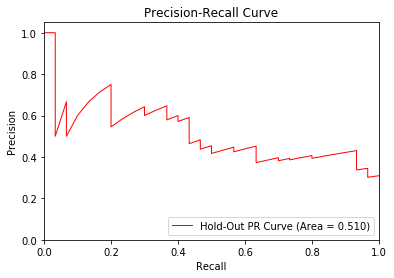

In [35]:
# Hold Out PR Curve
precision, recall, thresholds = precision_recall_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Hold-Out PR Curve (Area = %0.3f)' % prc_auc)

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

Original PRC area: 0.510


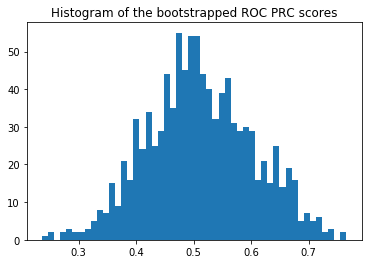

Confidence interval for the score: [0.336 - 0.695]


In [36]:
# Generate PRC 95% CI
print("Original PRC area: {:0.3f}".format(prc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    precision, recall, thresholds = precision_recall_curve(y_holdout[indices], y_pred_probs_ensemble[indices], pos_label=1)
    score = auc(recall, precision)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC PRC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))